# Demo — Topic recurrence

**Run Setup first (all cells below until "1. Data overview").**  
Then for each section (Topic labeling, Depth prompt, Clustering), run that section's **Preset** cell(s) before its main cells.

---
### Setup (run all cells in this section first)

In [20]:
# Setup: imports and helpers (run first)
import os
import duckdb
import pandas as pd
import numpy as np
from pathlib import Path

def read_parquet_any(path: str) -> pd.DataFrame:
    try:
        return pd.read_parquet(path, engine="pyarrow")
    except Exception:
        return pd.read_parquet(path, engine="fastparquet")

def write_parquet_any(df: pd.DataFrame, path: str) -> None:
    try:
        df.to_parquet(path, engine="pyarrow", index=False)
    except Exception:
        df.to_parquet(path, engine="fastparquet", index=False)

In [44]:
# Setup: paths and load core data (run after imports+helpers)
CONVO_INPUT_DATA_PATH = '/project/ycleong/datasets/CANDOR'
FRIENDS_INPUT_DATA_PATH = '/project/ycleong/datasets/Friends'
BACKBITER_PARQUET = os.path.join(CONVO_INPUT_DATA_PATH, 'backbiter_chunk_embed.parquet')
TOPIC_PARQUET = os.path.join(CONVO_INPUT_DATA_PATH, 'chunk_topic.parquet')
SURVEY_PARQUET = os.path.join(CONVO_INPUT_DATA_PATH, 'survey.ALL.parquet')
# FRIENDS_PARQUET = os.path.join(FRIENDS_INPUT_DATA_PATH, 'friends_chunk_topic.parquet')

backbiter = read_parquet_any(BACKBITER_PARQUET)
topic = read_parquet_any(TOPIC_PARQUET)
survey = read_parquet_any(SURVEY_PARQUET)
# friends = read_parquet_any(FRIENDS_PARQUET)


In [42]:
# Optional: check working directory
os.getcwd()

'/home/xpan02/topic_recurrence'

In [46]:
# (backbiter, survey, friends already loaded in Setup — cell 2)
topic.head()

,chunk_id,conversation_id,chunk_text,topic,embedding
0,0,0020a0c5-1658-4747-99c1-2839e736b481,"Mhm. Mhm. Just, mm. And Uh huh, mm. Mhm. Mhm. ...",-1,"[-0.018710755, -0.05603622, 0.008750842, -0.04..."
1,1,0020a0c5-1658-4747-99c1-2839e736b481,this is actually my first one so uh yeah it's ...,28,"[-0.008183039, -0.025526466, -0.0153701985, -0..."
2,2,0020a0c5-1658-4747-99c1-2839e736b481,"thanks, Tiny firm sponge. I swear that's that'...",15,"[0.010888462, -0.023096139, -0.031201828, -0.0..."
3,3,0020a0c5-1658-4747-99c1-2839e736b481,but I do really like sleep quite a bit and I h...,44,"[0.018100442, 0.011536207, -0.018537097, -0.05..."
4,4,0020a0c5-1658-4747-99c1-2839e736b481,that sounds really cute. So what are their nam...,15,"[0.034210533, 0.030619394, -0.014135093, 0.032..."


---
### 1. Data overview  
Uses: `backbiter`, `friends` from Setup. Run the cells below to inspect data.

In [6]:
backbiter.head()


,chunk_id,conversation_id,chunk_text,topic,embedding
0,0,0020a0c5-1658-4747-99c1-2839e736b481,"Mhm. Mhm. Just, mm. And Uh huh, mm. Mhm. Mhm. ...",-1,"[-0.018710755, -0.05603622, 0.008750842, -0.04..."
1,1,0020a0c5-1658-4747-99c1-2839e736b481,this is actually my first one so uh yeah it's ...,28,"[-0.008183039, -0.025526466, -0.0153701985, -0..."
2,2,0020a0c5-1658-4747-99c1-2839e736b481,"thanks, Tiny firm sponge. I swear that's that'...",15,"[0.010888462, -0.023096139, -0.031201828, -0.0..."
3,3,0020a0c5-1658-4747-99c1-2839e736b481,but I do really like sleep quite a bit and I h...,44,"[0.018100442, 0.011536207, -0.018537097, -0.05..."
4,4,0020a0c5-1658-4747-99c1-2839e736b481,that sounds really cute. So what are their nam...,15,"[0.034210533, 0.030619394, -0.014135093, 0.032..."


In [7]:
len(backbiter)

84358

In [8]:
backbiter["topic"].value_counts().sort_index()

topic
-1      43775
 0       3724
 1       2190
 2       1866
 3       1691
        ...  
 359       10
 360       10
 361       10
 362       10
 363       10
Name: count, Length: 365, dtype: int64

In [9]:
friends.head()

,chunk_id_orig,n_words,end_turn_id,start_turn_id,episode_id,season_id,scene_id,chunk_id,chunk_text,topic,topic_words
0,0,117,10,1,s01_e01,s01,s01_e01_c01,0,There's nothing to tell! He's just some guy I ...,-1,None
1,1,120,25,11,s01_e01,s01,s01_e01_c01,1,"Oh, yeah. Had that dream. Then I look down, an...",66,"dream, had, dreamt, he, bed, jack, night, saw,..."
2,2,109,39,26,s01_e01,s01,s01_e01_c01,2,Carol moved her stuff out today. Ohh. Let me g...,-1,None
3,3,103,48,40,s01_e01,s01,s01_e01_c01,3,"Oh really, so that hysterical phone call I got...",63,"married, rachel, annulment, rog, angelica, ros..."
4,4,112,55,49,s01_e01,s01,s01_e01_c01,4,Oh God Monica hi! Thank God! I just went to yo...,-1,None


In [10]:
len(friends)

7708

In [11]:
friends["topic"].value_counts().sort_index()

topic
-1     4095
 0      317
 1      279
 2      128
 3      120
       ... 
 84      11
 85      11
 86      10
 87      10
 88      10
Name: count, Length: 90, dtype: int64

---
### 2. Topic labeling (LLM)  
**Preset:** Run the next several cells in order: HF login → tokenizer/model (or InferenceClient) → constants & topics → `sample_topic_texts`, PROMPT, `build_prompt`, SYSTEM, `run_llm`. Then run the example at the end of this section.

In [47]:
# ---------- Preset: Section 2 (Topic labeling) — run this and the next Preset cells in order ----------
import torch
import accelerate
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import json
import numpy as np
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [48]:
import os
from huggingface_hub import login

# If you want downstream code to see HF_TOKEN, you must set the env var yourself.
# Load from environment (DO NOT hardcode tokens).
HF_TOKEN = os.getenv("HF_TOKEN")
if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN
    login(token=HF_TOKEN)
    print("HF_TOKEN env exists:", "HF_TOKEN" in os.environ)
    print("HF_TOKEN (masked):", HF_TOKEN[:8] + "..." if len(HF_TOKEN) > 8 else "***")
else:
    print("HF_TOKEN not set. Set it in .env or os.environ.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


HF_TOKEN env exists: True
HF_TOKEN (masked): hf_Xooce...


In [49]:
import sys, os, site, pathlib
print("python:", sys.executable)
print("prefix:", sys.prefix)
print("user site:", site.getusersitepackages())
print("HOME:", os.environ.get("HOME"))
print("HF_HOME env:", os.environ.get("HF_HOME"))
print("HF_TOKEN env exists:", "HF_TOKEN" in os.environ)
print("HF_TOKEN:", os.environ.get("HF_TOKEN", "")[:8], "..." if os.environ.get("HF_TOKEN") else "")


python: /software/python-anaconda-2023.09-el8-x86_64/envs/rapids-24.12/bin/python
prefix: /software/python-anaconda-2023.09-el8-x86_64/envs/rapids-24.12
user site: /home/xpan02/.local/lib/python3.12/site-packages
HOME: /home/xpan02
HF_HOME env: None
HF_TOKEN env exists: True
HF_TOKEN: hf_Xooce ...


In [50]:
import os
from huggingface_hub import HfApi

print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_TOKEN set?:", "HF_TOKEN" in os.environ)

api = HfApi()
try:
    # If HF_TOKEN isn't set, let huggingface_hub fall back to cached credentials.
    token = os.environ.get("HF_TOKEN")
    info = (
        api.model_info("Qwen/Qwen2.5-3B-Instruct", token=token)
        if token
        else api.model_info("Qwen/Qwen2.5-3B-Instruct")
    )
    print("ACCESS OK:", info.modelId)
except Exception as e:
    print("ACCESS FAIL:", repr(e))


HF_HOME: None
HF_TOKEN set?: True
ACCESS OK: Qwen/Qwen2.5-3B-Instruct


In [51]:
import os
import importlib
import transformers.utils.import_utils as _import_utils
from huggingface_hub import InferenceClient

importlib.reload(_import_utils)
from transformers.utils.import_utils import is_accelerate_available
print("is_accelerate_available:", is_accelerate_available())

model_id = "Qwen/Qwen2.5-3B-Instruct"

# Always load tokenizer (lightweight).
tok = AutoTokenizer.from_pretrained(
    model_id,
    token=os.environ.get("HF_TOKEN"),
)

# Some tokenizers don't define a pad token by default.
if tok.pad_token_id is None and tok.eos_token_id is not None:
    tok.pad_token = tok.eos_token

# Qwen 3B fits on 1 GPU (or CPU, though slower). Load locally.
# Note: Qwen models are not available via Hugging Face Inference API, so we must load locally.
client = None
model = None

if torch.cuda.is_available():
    torch_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch_dtype,
        token=os.environ.get("HF_TOKEN"),
    )
    model.eval()
    print("Loaded local model on CUDA")
else:
    # Load on CPU (slower but works). Qwen 3B is small enough for CPU.
    print("No CUDA detected; loading model on CPU (this may be slow)")
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="cpu",
        torch_dtype=torch.float32,
        token=os.environ.get("HF_TOKEN"),
    )
    model.eval()
    print("Loaded local model on CPU")


is_accelerate_available: True


`torch_dtype` is deprecated! Use `dtype` instead!


No CUDA detected; loading model on CPU (this may be slow)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 

In [ ]:
OUT_CSV = "topic-label_all.csv"

N_PER_TOPIC = 10
SEED = 42

In [ ]:
backbiter.head()

,chunk_id,conversation_id,chunk_text,topic,embedding
0,0,0020a0c5-1658-4747-99c1-2839e736b481,"Mhm. Mhm. Just, mm. And Uh huh, mm. Mhm. Mhm. ...",-1,"[-0.018710755, -0.05603622, 0.008750842, -0.04..."
1,1,0020a0c5-1658-4747-99c1-2839e736b481,this is actually my first one so uh yeah it's ...,28,"[-0.008183039, -0.025526466, -0.0153701985, -0..."
2,2,0020a0c5-1658-4747-99c1-2839e736b481,"thanks, Tiny firm sponge. I swear that's that'...",15,"[0.010888462, -0.023096139, -0.031201828, -0.0..."
3,3,0020a0c5-1658-4747-99c1-2839e736b481,but I do really like sleep quite a bit and I h...,44,"[0.018100442, 0.011536207, -0.018537097, -0.05..."
4,4,0020a0c5-1658-4747-99c1-2839e736b481,that sounds really cute. So what are their nam...,15,"[0.034210533, 0.030619394, -0.014135093, 0.032..."


In [ ]:
topics = sorted(backbiter["topic"].dropna().unique().tolist())
topics[:10], topics[-10:]

([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [354, 355, 356, 357, 358, 359, 360, 361, 362, 363])

In [ ]:
topics_no_noise = [t for t in topics if t != -1]
len(topics), len(topics_no_noise)

(365, 364)

In [ ]:
def sample_topic_texts(group: pd.DataFrame, n: int = 20, seed: int = 42) -> list[str]:
    return (
        group["chunk_text"]
        .dropna()
        .astype(str)
        .sample(n=min(n, len(group)), random_state=seed)
        .tolist()
    )

In [ ]:
t = topics_no_noise[0]
group = backbiter[backbiter["topic"] == t]
examples = sample_topic_texts(group, n=N_PER_TOPIC, seed=SEED)

len(examples), examples[0][:200]

(10,
 "Yeah, a wimp. So what I'm gonna say? Yeah. Because I mean dogs and cats don't sweat on like most of their skin. So I think like we think for would be really hot but that's because we would be sweating")

In [ ]:
PROMPT = """
You are an expert annotator analyzing a latent conversation topic.
All the text chunks below come from the same topic.

### Topic ID: {topic_id}

### Example text chunks
{chunk_examples}

### Task
Based on these examples, infer the underlying topic.
Produce only a one-row Markdown table with:

- topic_id: {topic_id}
- short_label: a concise 2–5 word name
- summary: one sentence describing what people are doing or discussing in this topic
- keywords: 3–8 key words or phrases (comma separated)

### Output format (very important)
| topic_id | short_label | summary | keywords |
|----------|-------------|---------|----------|
| {topic_id} | ... | ... | ... |

Do not add extra commentary.
""".strip()


In [ ]:
def build_prompt(topic_id: int, chunk_examples: list[str]) -> str:
    chunk_examples_block = "\n".join([f"- {i+1}. {text}" for i, text in enumerate(chunk_examples)])
    return PROMPT.format(topic_id=topic_id, chunk_examples=chunk_examples_block)

prompt = build_prompt(t, examples)
print(prompt[:1500])

You are an expert annotator analyzing a latent conversation topic.
All the text chunks below come from the same topic.

### Topic ID: 0

### Example text chunks
- 1. Yeah, a wimp. So what I'm gonna say? Yeah. Because I mean dogs and cats don't sweat on like most of their skin. So I think like we think for would be really hot but that's because we would be sweating. But they're not sweating in those areas. They're just sweating on their pads and their tongues. yep. Yeah and if the ground is like a bazillion degrees that's not helpful and New studies available on prolific. There are no new studies available and prolific. Sorry about that. uh that's but uh like at at on or something, Yeah. Yeah. That's that's how we get them.
- 2. Yeah, we found that we were we got stuff on it on facebook and and text but it took a while because of the you know self service was down. So so like um toe furs are steps, steps on what my steps And his wife Amber, her mom lived there and she was one of those p

In [ ]:
SYSTEM = "You are an expert annotator analyzing a latent conversation topic."

def run_llm(prompt: str, max_new_tokens: int = 200) -> str:
    """Run Qwen model locally (Qwen models are not available via Inference API)."""
    messages = [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": prompt},
    ]

    # Qwen models must be loaded locally (Inference API doesn't support them)
    if "model" not in globals() or model is None:
        raise RuntimeError("Model not loaded. Run the model loading cell (Section 2 Preset) first.")

    inputs = tok.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            top_p=1.0,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )

    gen = out[0, inputs.shape[-1]:]
    return tok.decode(gen, skip_special_tokens=True).strip()


In [ ]:
prompt = "In one sentence, what is this text about?\nI am stressed about school and money."

print(run_llm(prompt, max_new_tokens=40))


StopIteration: 

In [27]:
raw = run_llm(prompt, max_new_tokens=220)
print(raw)


| topic_id | short_label | summary | keywords |
|----------|-------------|---------|----------|
| 0 | Pet Ownership | People are discussing their experiences and concerns about having pets, including their behavior, health, and care. | pets, animals, cats, dogs, responsibility, pet care, animal health |


---
### 3. Test depth prompt (for 2b_rate_depth.py)  
**Preset:** Run the cell below (DEPTH_PROMPT, `build_depth_prompt`). Requires `run_llm` and `backbiter` from Section 2 and Setup.

Rate each chunk's "depth" (reflection, substance, self-disclosure vs small talk). Same prompt is used in `scripts/2b_rate_depth.py`.

In [24]:
# Prompt used in 2b_rate_depth.py for LLM-based depth (test here before batch run)
DEPTH_PROMPT = """You are an expert annotator rating conversation depth.

### Chunk to rate
{chunk_text}

### Task
Rate the depth of this conversation chunk on a scale from 1 to 7.

Depth refers to the extent to which speakers engage in:
- self-disclosure about internal states (thoughts, feelings, experiences)
- reflective processing (explaining meaning, causes, changes, identity)
- substantive intellectual or emotional engagement

Use the following anchors:

1 = Purely surface-level (greetings, logistics, weather, coordination, filler)
2 = Mostly factual or transactional; no internal states expressed
3 = Mild personal opinions or preferences; limited elaboration
4 = Some personal experience mentioned but little reflection
5 = Clear self-disclosure of thoughts or feelings
6 = Reflective processing (explaining why something matters or what it means)
7 = Deep reflection or vulnerability involving identity, life meaning, or emotional insight

Important:
- Emotional intensity alone does not equal depth.
- Topic seriousness alone does not equal depth.
- Rate based on reflective or self-referential engagement.

Reply with exactly two lines:
depth_score: <integer from 1 to 7>
reason: <one short phrase describing why>
"""


def build_depth_prompt(chunk_text: str) -> str:
    return DEPTH_PROMPT.format(chunk_text=(chunk_text or "").strip()[:1500])

In [25]:
# Test on 2 sample chunks from backbiter (run after loading backbiter and run_llm)
samples = backbiter["chunk_text"].dropna().astype(str).sample(n=2, random_state=99).tolist()
for i, text in enumerate(samples):
    prompt = build_depth_prompt(text)
    out = run_llm(prompt, max_new_tokens=80)
    print(f"--- Chunk {i+1} (first 120 chars): {text[:120]}...")
    print(out)
    print()

NameError: name 'run_llm' is not defined

---
### 4. Clustering topics with labels  
**Preset:** Run the first code cell below (load CSV, parse embeddings, X_normalized, optimal k, cluster assignments). Then run the rest (visualization, summary tables).

Uses **data/topic-label_all.csv** (with `topic_embedding`). Cluster topic embeddings and show **short_label** per cluster.

In [35]:
# ---------- Preset: Section 4 (Clustering) — run this first, then visualization/summary cells ----------
# Load topic labels + embeddings (from 3_label_bertopics.py output)
from ast import literal_eval
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

TOPIC_LABEL_CSV = "data/topic-label_all.csv"
df_labels = pd.read_csv(TOPIC_LABEL_CSV)

if "topic_embedding" not in df_labels.columns:
    raise ValueError(
        "topic_embedding column missing. Regenerate CSV with: "
        "scripts/3_label_bertopics.py (and ensure chunk_topic.parquet has embedding column from 2_topic_modeling.py)"
    )

# Parse topic_embedding string -> array (CSV may store "[np.float64(x), ...]" which literal_eval can't parse)
def parse_embedding(s):
    s = str(s).strip()
    if s.startswith("[") and "np.float64" in s:
        s = s.replace("np.float64(", "").replace(")", "")
    return np.array(literal_eval(s), dtype=np.float32)

df_labels = df_labels.dropna(subset=["topic_embedding"]).copy()
df_labels["emb"] = df_labels["topic_embedding"].apply(parse_embedding)
X = np.vstack(df_labels["emb"].to_numpy()).astype(np.float32)

# Exclude noise topic -1 for clustering (or keep it)
mask = df_labels["topic_id"] != -1
X_cluster = X[mask]
df_cluster = df_labels.loc[mask].reset_index(drop=True)
if len(df_cluster) == 0:
    raise ValueError("No rows left after optional -1 filter.")

# Normalize once for all clustering
X_normalized = normalize(X_cluster, norm='l2')

In [36]:
# Evaluate optimal number of clusters using silhouette score and elbow method
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans  # For elbow method (inertia)

# Try different numbers of clusters
k_range = range(2, min(31, len(X_cluster) // 2))  # Test 2 to 30 clusters (or half the data size)
silhouette_scores = []
db_scores = []
inertias = []

print("Evaluating cluster numbers...")
for k in k_range:
    # Use AgglomerativeClustering (same as final clustering)
    agg_temp = AgglomerativeClustering(n_clusters=k)
    labels_temp = agg_temp.fit_predict(X_normalized)
    
    # Silhouette score (higher is better, range: -1 to 1)
    sil_score = silhouette_score(X_normalized, labels_temp)
    silhouette_scores.append(sil_score)
    
    # Davies-Bouldin index (lower is better)
    db_score = davies_bouldin_score(X_normalized, labels_temp)
    db_scores.append(db_score)
    
    # For elbow method, compute inertia using KMeans (approximation)
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_normalized)
    inertias.append(kmeans_temp.inertia_)

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(db_scores)]

print(f"Optimal clusters (silhouette): {optimal_k_silhouette} (score: {max(silhouette_scores):.3f})")
print(f"Optimal clusters (Davies-Bouldin): {optimal_k_db} (score: {min(db_scores):.3f})")

Evaluating cluster numbers...
Optimal clusters (silhouette): 27 (score: 0.075)
Optimal clusters (Davies-Bouldin): 30 (score: 2.349)


Clustered with Silhouette-best: k=27, Davies-Bouldin-best: k=30


/home/xpan02/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


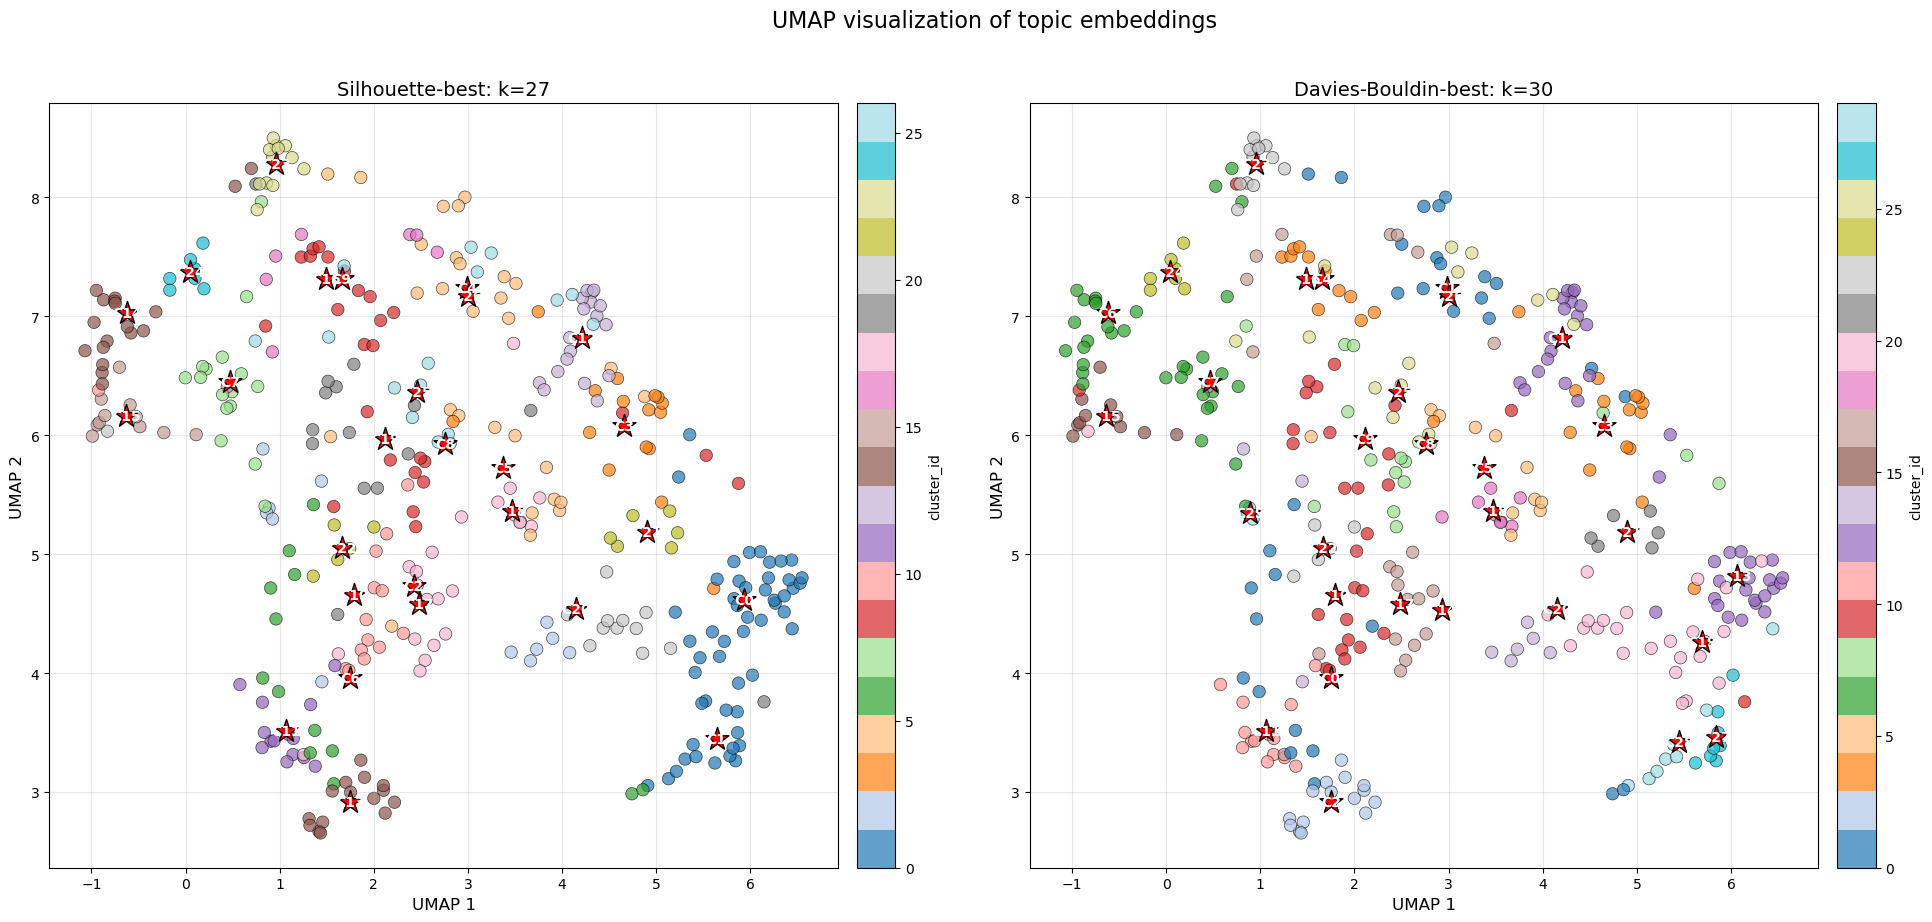

In [37]:
# Cluster with BOTH optimal k values (if not already done)
if "cluster_id_sil" not in df_cluster.columns:
    from sklearn.cluster import AgglomerativeClustering
    n_clusters_sil = optimal_k_silhouette
    n_clusters_db = optimal_k_db
    agg_clustering_sil = AgglomerativeClustering(n_clusters=n_clusters_sil)
    cluster_id_sil = agg_clustering_sil.fit_predict(X_normalized)
    
    agg_clustering_db = AgglomerativeClustering(n_clusters=n_clusters_db)
    cluster_id_db = agg_clustering_db.fit_predict(X_normalized)
    
    df_cluster["cluster_id_sil"] = cluster_id_sil
    df_cluster["cluster_id_db"] = cluster_id_db
    df_labels.loc[mask, "cluster_id_sil"] = cluster_id_sil
    df_labels.loc[mask, "cluster_id_db"] = cluster_id_db
    df_labels.loc[~mask, "cluster_id_sil"] = -1
    df_labels.loc[~mask, "cluster_id_db"] = -1
    
    print(f"Clustered with Silhouette-best: k={n_clusters_sil}, Davies-Bouldin-best: k={n_clusters_db}")
else:
    # Variables already exist, just get the k values
    n_clusters_sil = len(df_cluster["cluster_id_sil"].unique())
    n_clusters_db = len(df_cluster["cluster_id_db"].unique())

# Reduce to 2D using UMAP and plot BOTH optimal clusterings side-by-side
import umap
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X2_umap = reducer.fit_transform(X_normalized)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Left: Silhouette-best clustering
ax1 = axes[0]
sc1 = ax1.scatter(X2_umap[:, 0], X2_umap[:, 1], c=df_cluster["cluster_id_sil"], cmap="tab20", 
                  alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
for cid in sorted(df_cluster["cluster_id_sil"].unique()):
    mask_cid = df_cluster["cluster_id_sil"] == cid
    if mask_cid.sum() > 0:
        centroid = X2_umap[mask_cid].mean(axis=0)
        ax1.scatter(centroid[0], centroid[1], c='red', marker='*', s=300, edgecolors='black', linewidth=1, zorder=10)
        ax1.annotate(f'C{cid}', (centroid[0], centroid[1]), fontsize=10, fontweight='bold', 
                    ha='center', va='center', color='white', zorder=11)
ax1.set_xlabel("UMAP 1", fontsize=12)
ax1.set_ylabel("UMAP 2", fontsize=12)
n_clusters_sil = optimal_k_silhouette if "cluster_id_sil" not in df_cluster.columns else len(df_cluster["cluster_id_sil"].unique())
n_clusters_db = optimal_k_db if "cluster_id_db" not in df_cluster.columns else len(df_cluster["cluster_id_db"].unique())
ax1.set_title(f"Silhouette-best: k={n_clusters_sil}", fontsize=14)
plt.colorbar(sc1, ax=ax1, label="cluster_id", pad=0.02)
ax1.grid(True, alpha=0.3)

# Right: Davies-Bouldin-best clustering
ax2 = axes[1]
sc2 = ax2.scatter(X2_umap[:, 0], X2_umap[:, 1], c=df_cluster["cluster_id_db"], cmap="tab20", 
                  alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
for cid in sorted(df_cluster["cluster_id_db"].unique()):
    mask_cid = df_cluster["cluster_id_db"] == cid
    if mask_cid.sum() > 0:
        centroid = X2_umap[mask_cid].mean(axis=0)
        ax2.scatter(centroid[0], centroid[1], c='red', marker='*', s=300, edgecolors='black', linewidth=1, zorder=10)
        ax2.annotate(f'C{cid}', (centroid[0], centroid[1]), fontsize=10, fontweight='bold', 
                    ha='center', va='center', color='white', zorder=11)
ax2.set_xlabel("UMAP 1", fontsize=12)
ax2.set_ylabel("UMAP 2", fontsize=12)
ax2.set_title(f"Davies-Bouldin-best: k={n_clusters_db}", fontsize=14)
plt.colorbar(sc2, ax=ax2, label="cluster_id", pad=0.02)
ax2.grid(True, alpha=0.3)

plt.suptitle("UMAP visualization of topic embeddings", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [38]:
# REPLACE CELL 32: Cluster with BOTH optimal k values
# Silhouette-best clustering
n_clusters_sil = optimal_k_silhouette
agg_clustering_sil = AgglomerativeClustering(n_clusters=n_clusters_sil)
cluster_id_sil = agg_clustering_sil.fit_predict(X_normalized)

# Davies-Bouldin-best clustering  
n_clusters_db = optimal_k_db
agg_clustering_db = AgglomerativeClustering(n_clusters=n_clusters_db)
cluster_id_db = agg_clustering_db.fit_predict(X_normalized)

# Store both results
df_cluster["cluster_id_sil"] = cluster_id_sil
df_cluster["cluster_id_db"] = cluster_id_db
df_labels.loc[mask, "cluster_id_sil"] = cluster_id_sil
df_labels.loc[mask, "cluster_id_db"] = cluster_id_db
df_labels.loc[~mask, "cluster_id_sil"] = -1
df_labels.loc[~mask, "cluster_id_db"] = -1

print(f"Silhouette-best: n_clusters={n_clusters_sil}")
print(f"Davies-Bouldin-best: n_clusters={n_clusters_db}")
print(f"\nClustered {len(df_cluster)} topics (topic_id -1 kept as noise).")
print("\nPreview (Silhouette-best):")
display(df_cluster[["topic_id", "short_label", "cluster_id_sil"]].head(10))

Silhouette-best: n_clusters=27
Davies-Bouldin-best: n_clusters=30

Clustered 359 topics (topic_id -1 kept as noise).

Preview (Silhouette-best):


,topic_id,short_label,cluster_id_sil
0,0,Pet Talk,19
1,1,Movie/TV Chat,2
2,2,Job Interview,23
3,3,Online Learning,13
4,4,Election Issues,4
5,5,Weather Discussion,0
6,6,Food Preferences,18
7,7,Gaming Memories,7
8,8,Mask Usage,19
9,9,Sports Talk,20


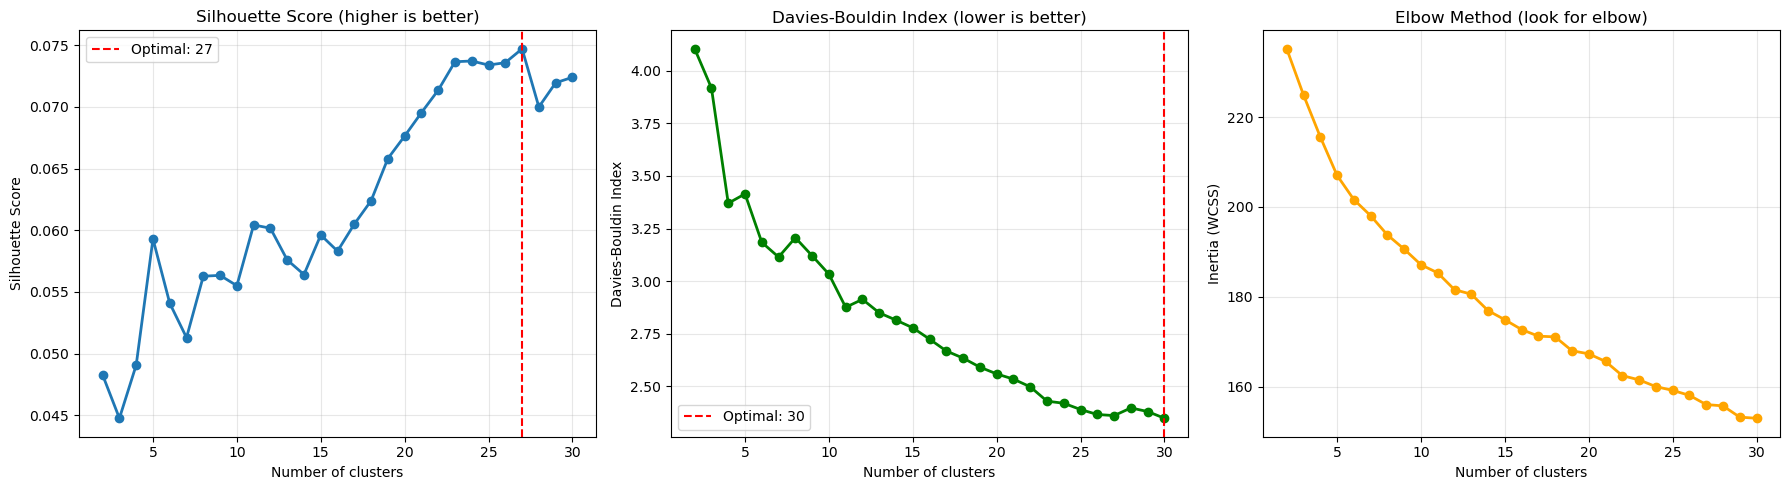


Top 5 cluster numbers by silhouette score:
  k=27: 0.075
  k=24: 0.074
  k=23: 0.074
  k=26: 0.074
  k=25: 0.073


In [39]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette score
axes[0].plot(list(k_range), silhouette_scores, marker='o', linewidth=2, markersize=6)
axes[0].axvline(optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal: {optimal_k_silhouette}')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score (higher is better)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Davies-Bouldin index
axes[1].plot(list(k_range), db_scores, marker='o', color='green', linewidth=2, markersize=6)
axes[1].axvline(optimal_k_db, color='r', linestyle='--', label=f'Optimal: {optimal_k_db}')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Elbow method (inertia)
axes[2].plot(list(k_range), inertias, marker='o', color='orange', linewidth=2, markersize=6)
axes[2].set_xlabel('Number of clusters')
axes[2].set_ylabel('Inertia (WCSS)')
axes[2].set_title('Elbow Method (look for elbow)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show top candidates
print("\nTop 5 cluster numbers by silhouette score:")
top_sil = sorted(zip(k_range, silhouette_scores), key=lambda x: x[1], reverse=True)[:5]
for k, score in top_sil:
    print(f"  k={k}: {score:.3f}")

In [40]:
# Cluster using AgglomerativeClustering with optimal number of clusters
# Use the optimal k from silhouette score (or manually set if preferred)
# Options: optimal_k_silhouette, optimal_k_db, or set manually like n_clusters = 12
n_clusters = optimal_k_silhouette  # Change this to try different k values
print(f"\nClustering with n_clusters={n_clusters} (from silhouette score)")
print(f"To try a different k, change n_clusters above (e.g., n_clusters = {optimal_k_db} for DB optimal)")

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_id = agg_clustering.fit_predict(X_normalized)
df_cluster["cluster_id"] = cluster_id
df_labels.loc[mask, "cluster_id"] = cluster_id
df_labels.loc[~mask, "cluster_id"] = -1  # noise

print(f"Clustered {len(df_cluster)} topics into {n_clusters} clusters (topic_id -1 kept as noise).")
df_cluster[["topic_id", "short_label", "cluster_id"]].head(10)


Clustering with n_clusters=27 (from silhouette score)
To try a different k, change n_clusters above (e.g., n_clusters = 30 for DB optimal)
Clustered 359 topics into 27 clusters (topic_id -1 kept as noise).


,topic_id,short_label,cluster_id
0,0,Pet Talk,19
1,1,Movie/TV Chat,2
2,2,Job Interview,23
3,3,Online Learning,13
4,4,Election Issues,4
5,5,Weather Discussion,0
6,6,Food Preferences,18
7,7,Gaming Memories,7
8,8,Mask Usage,19
9,9,Sports Talk,20


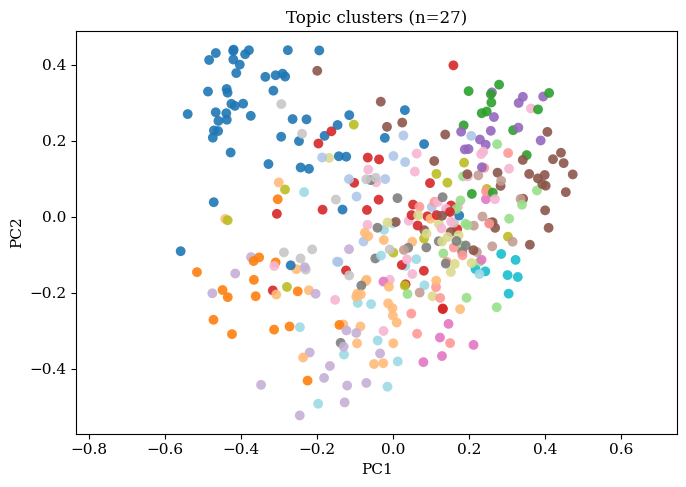

PCA variance explained: PC1=8.6%, PC2=6.4%, Total=15.0%


In [46]:
# Clean 2D map: one scatter, distinct cluster colors only
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_normalized)

fig, ax = plt.subplots(figsize=(7, 5), facecolor="white")
ax.set_facecolor("white")

# Single scatter — cluster_id maps to distinct colors (tab20)
sc = ax.scatter(
    X2[:, 0], X2[:, 1],
    c=df_cluster["cluster_id"],
    cmap="tab20",
    s=50,
    alpha=0.9,
    edgecolors="none",
)

ax.set_xlabel("PC1", fontsize=11)
ax.set_ylabel("PC2", fontsize=11)
ax.set_title(f"Topic clusters (n={n_clusters})", fontsize=12)
ax.set_aspect("equal", adjustable="datalim")
plt.tight_layout()
plt.show()

print(f"PCA variance explained: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}, Total={pca.explained_variance_ratio_.sum():.1%}")

In [42]:
# Summary: clusters with labels (print FULL table, not preview)
cluster_summary = (
    df_cluster.groupby("cluster_id")
    .agg(
        topic_ids=("topic_id", list),
        short_labels=("short_label", list),
        n_topics=("topic_id", "count"),
    )
    .reset_index()
    .sort_values("cluster_id")
)
cluster_summary["example_label"] = cluster_summary["short_labels"].apply(lambda x: x[0] if x else None)

# Print full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

print(f"\nFull cluster summary (n_clusters={n_clusters}):")
print("=" * 100)
display(cluster_summary[["cluster_id", "n_topics", "example_label", "short_labels"]])


Full cluster summary (n_clusters=27):


,cluster_id,n_topics,example_label,short_labels
0,0,36,Weather Discussion,"[Weather Discussion, Travel Planning, Urban Life, Texas Talk, Hiking & Nature, Travel & Jobs, Lo..."
1,1,16,Language Learning,"[Language Learning, Accent Recognition, Cultural Comparisons, Immigration Docs, Traveling & Educ..."
2,2,12,Movie/TV Chat,"[Movie/TV Chat, Music Preferences, Theater & Events, Movie Theater, Music Discussion, Ticket Acc..."
3,3,16,Housing Costs,"[Housing Costs, COVID reopening, Wildfires Discussion, COVID Updates, Weather Events, Protests &..."
4,4,18,Election Issues,"[Election Issues, Religious Discussions, Race & Prejudice, Social Critique, Healthcare Issues, P..."
5,5,11,Grocery Delivery,"[Grocery Delivery, Decluttering & Shopping, Toilet Paper Crisis, Store Restrictions, Grocery Sho..."
6,6,13,Crafting & Art,"[Crafting & Art, Music Education, Writing & Publishing, Teaching, Teaching Online, Teaching Chal..."
7,7,16,Gaming Memories,"[Gaming Memories, Video Chat Issues, Tech Gadgets, Internet Issues, Streaming & TV, Video Confer..."
8,8,15,Sleep & Schedule,"[Sleep & Schedule, Social Isolation, Holiday Plans, Age & Growth, Hobbies & Activities, Hallowee..."
9,9,11,Online Chatting,"[Online Chatting, Wedding Plans, Identity & Acceptance, Online Dating, Chatting Match, Singles t..."


In [43]:
# Try different optimal k values and compare results
print("=" * 80)
print("COMPARING DIFFERENT OPTIMAL K VALUES")
print("=" * 80)

# Try top 3 k values from silhouette score
top_k_values = sorted(zip(k_range, silhouette_scores), key=lambda x: x[1], reverse=True)[:3]
k_to_try = [k for k, _ in top_k_values] + [optimal_k_db]  # Include DB optimal too
k_to_try = sorted(set(k_to_try))  # Remove duplicates

results_comparison = []

for k_test in k_to_try:
    agg_test = AgglomerativeClustering(n_clusters=k_test)
    labels_test = agg_test.fit_predict(X_normalized)
    
    sil = silhouette_score(X_normalized, labels_test)
    db = davies_bouldin_score(X_normalized, labels_test)
    
    # Count cluster sizes
    unique, counts = np.unique(labels_test, return_counts=True)
    min_size = counts.min()
    max_size = counts.max()
    mean_size = counts.mean()
    
    results_comparison.append({
        'k': k_test,
        'silhouette': sil,
        'davies_bouldin': db,
        'min_cluster_size': min_size,
        'max_cluster_size': max_size,
        'mean_cluster_size': f"{mean_size:.1f}",
        'n_clusters': len(unique)
    })
    
    print(f"\nk={k_test}: silhouette={sil:.3f}, DB={db:.3f}, sizes: min={min_size}, max={max_size}, mean={mean_size:.1f}")

comparison_df = pd.DataFrame(results_comparison)
print("\n" + "=" * 80)
print("COMPARISON TABLE:")
print("=" * 80)
display(comparison_df)

COMPARING DIFFERENT OPTIMAL K VALUES

k=23: silhouette=0.074, DB=2.430, sizes: min=6, max=36, mean=15.6

k=24: silhouette=0.074, DB=2.420, sizes: min=6, max=36, mean=15.0

k=27: silhouette=0.075, DB=2.362, sizes: min=6, max=36, mean=13.3

k=30: silhouette=0.072, DB=2.349, sizes: min=3, max=23, mean=12.0

COMPARISON TABLE:


,k,silhouette,davies_bouldin,min_cluster_size,max_cluster_size,mean_cluster_size,n_clusters
0,23,0.073667,2.430066,6,36,15.6,23
1,24,0.073730,2.420210,6,36,15.0,24
2,27,0.074717,2.361604,6,36,13.3,27
3,30,0.072407,2.348984,3,23,12.0,30


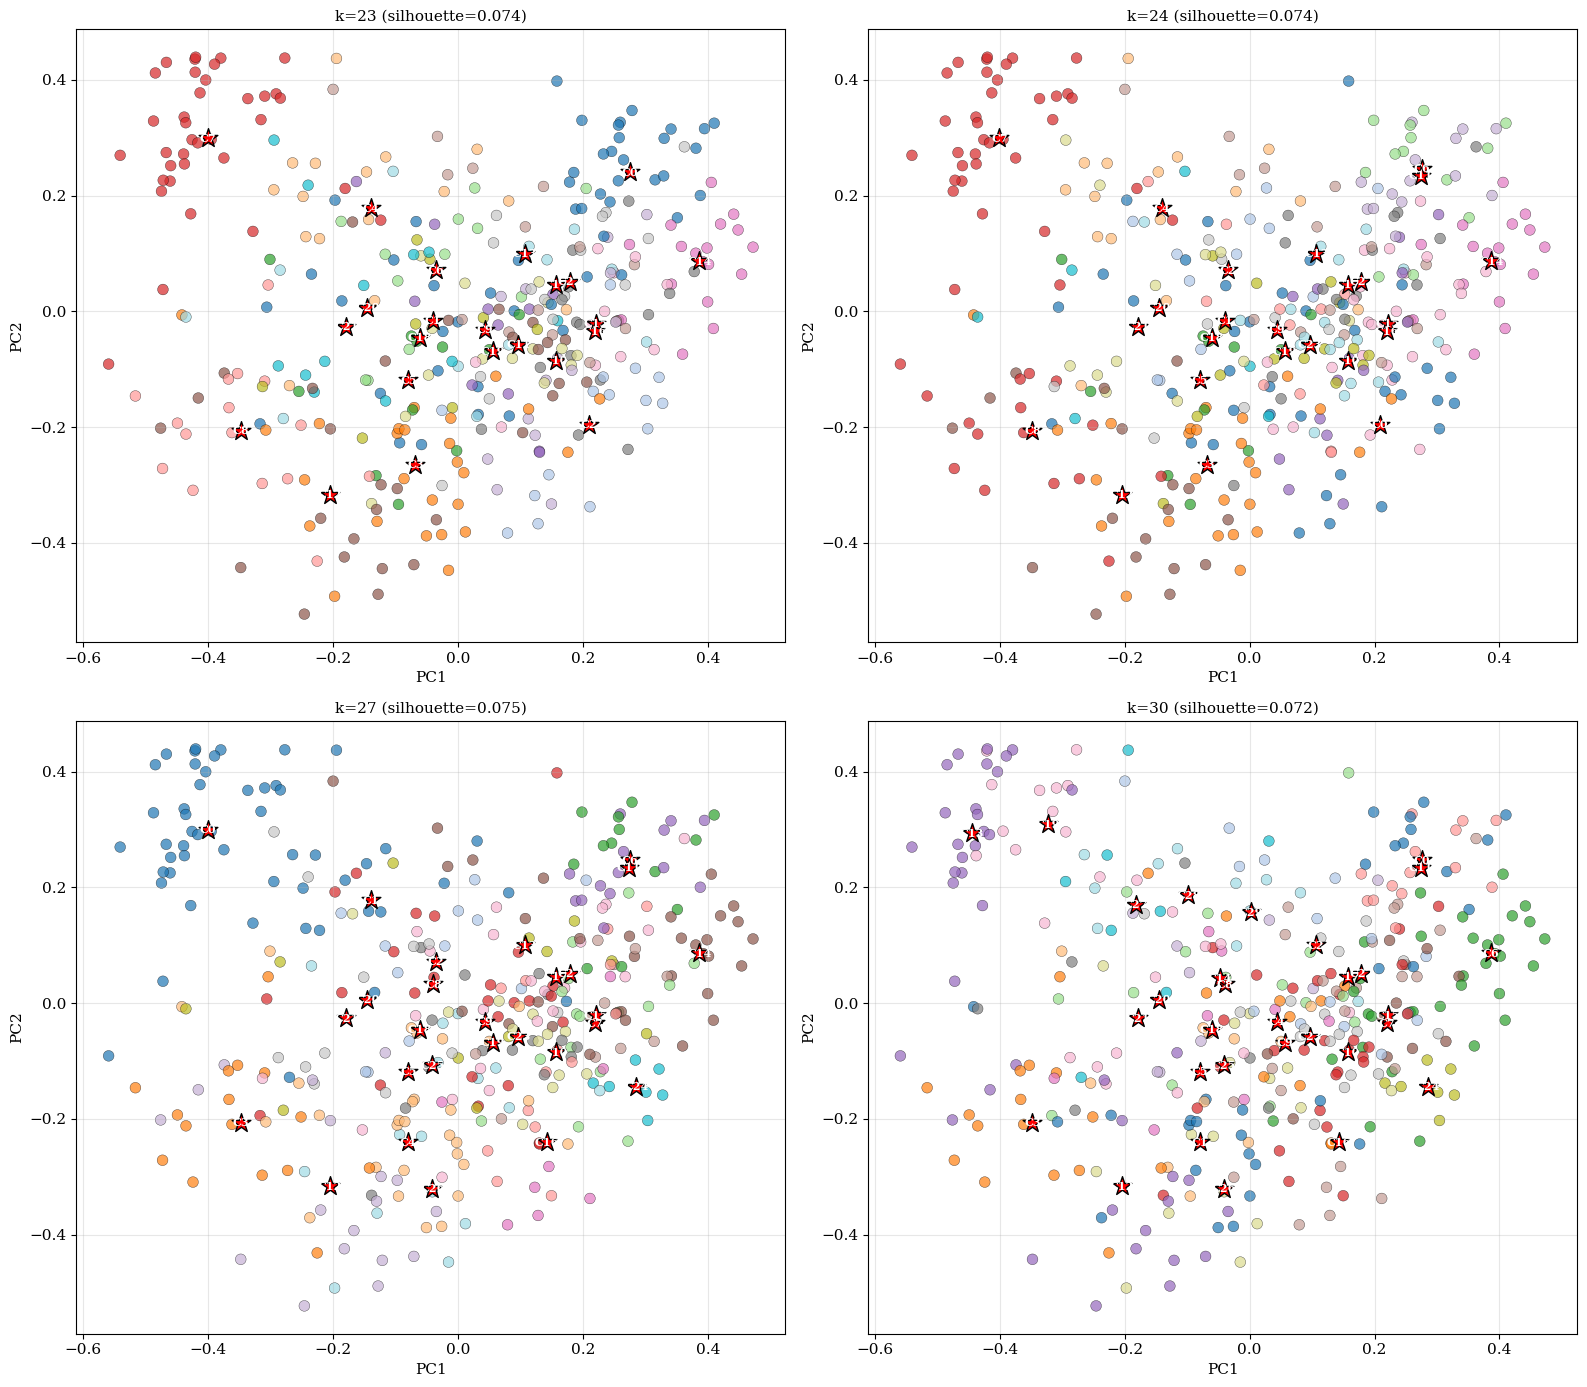

In [44]:
# Visualize different k values side-by-side
n_comparisons = min(4, len(k_to_try))
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, k_test in enumerate(k_to_try[:n_comparisons]):
    agg_test = AgglomerativeClustering(n_clusters=k_test)
    labels_test = agg_test.fit_predict(X_normalized)
    
    ax = axes[idx]
    sc = ax.scatter(X2[:, 0], X2[:, 1], c=labels_test, cmap="tab20", alpha=0.7, s=60, edgecolors='black', linewidth=0.3)
    
    # Add centroids
    for cid in sorted(set(labels_test)):
        mask_cid = labels_test == cid
        if mask_cid.sum() > 0:
            centroid = X2[mask_cid].mean(axis=0)
            ax.scatter(centroid[0], centroid[1], c='red', marker='*', s=200, edgecolors='black', linewidth=1, zorder=10)
            ax.annotate(f'C{cid}', (centroid[0], centroid[1]), fontsize=8, fontweight='bold', 
                       ha='center', va='center', color='white', zorder=11)
    
    sil = silhouette_score(X_normalized, labels_test)
    ax.set_title(f'k={k_test} (silhouette={sil:.3f})', fontsize=11)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_comparisons, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [45]:
df_cluster["cluster_id"].value_counts().sort_index()

cluster_id
0     36
1     16
2     12
3     16
4     18
5     11
6     13
7     16
8     15
9     11
10    14
11    14
12    18
13    15
14    18
15    11
16     8
17    15
18     8
19    15
20    12
21     6
22     6
23    12
24     7
25     8
26     8
Name: count, dtype: int64

---
### 5. Test cluster labeling prompt (for 5_label_clusters.py)  
**Preset:** Run the cell below (CLUSTER_PROMPT, `format_topic_summaries`, `build_cluster_prompt`). Requires `run_llm` from Section 2, and `topic_cluster_map.csv` + `topic-label_all.csv`.

Tests the prompt used in `scripts/5_label_clusters.py` to label clusters based on their constituent topic labels.

In [ ]:
# ---------- Preset: Section 5 (Cluster labeling) — prompt from 5_label_clusters.py ----------
# Prompt used in 5_label_clusters.py for LLM-based cluster labeling
CLUSTER_PROMPT = """You are an expert annotator analyzing a group of related conversation topics that form a cluster.
All the topics below belong to the same cluster.

### Cluster ID: {cluster_id}

### Topics in this cluster
{topic_summaries}

### Task
Based on these topics, infer the overarching theme or category that unifies them.
Produce only a one-row Markdown table with:

- cluster_id: {cluster_id}
- cluster_label: a concise 2–5 word name for this cluster
- cluster_summary: one sentence describing the common theme or category
- cluster_keywords: 3–8 key words or phrases (comma separated)

### Output format (very important)
| cluster_id | cluster_label | cluster_summary | cluster_keywords |
|------------|---------------|-----------------|------------------|
| {cluster_id} | ... | ... | ... |

Do not add extra commentary."""

CLUSTER_SYSTEM = "You are an expert annotator analyzing groups of related conversation topics."

def format_topic_summaries(df_topics: pd.DataFrame) -> str:
    """Format topic labels into a readable summary block for the prompt (same as 5_label_clusters.py)."""
    lines = []
    for idx, row in df_topics.iterrows():
        topic_id = row.get("topic_id", idx)
        short_label = row.get("short_label", "N/A")
        summary = row.get("summary", "")
        keywords = row.get("keywords", "")
        
        parts = [f"Topic {topic_id}: {short_label}"]
        if summary:
            parts.append(f"Summary: {summary}")
        if keywords:
            parts.append(f"Keywords: {keywords}")
        lines.append("- " + " | ".join(parts))
    return "\n".join(lines)

def build_cluster_prompt(cluster_id: int, topic_summaries: str) -> str:
    return CLUSTER_PROMPT.format(cluster_id=cluster_id, topic_summaries=topic_summaries)

In [ ]:
# Test on one cluster: load cluster map + topic labels, merge, format one cluster, run prompt
# Requires: run_llm from Section 2, and data files from scripts 4_cluster_topics.py and 3_label_bertopics.py
CLUSTER_MAP_CSV = "data/topic_cluster_map.csv"
TOPIC_LABEL_CSV = "data/topic-label_all.csv"

# Load cluster map and topic labels
cluster_map = pd.read_csv(CLUSTER_MAP_CSV)
topic_labels = pd.read_csv(TOPIC_LABEL_CSV)

# Merge to get topics per cluster
df_cluster_topics = cluster_map.merge(topic_labels, on="topic_id", how="inner")

# Pick one cluster to test (e.g., cluster_id 0 or one with several topics)
test_cluster_id = df_cluster_topics["cluster_id"].value_counts().index[0]  # Most common cluster
df_test = df_cluster_topics[df_cluster_topics["cluster_id"] == test_cluster_id].copy()

print(f"Testing cluster {test_cluster_id} with {len(df_test)} topics:")
print(f"Topics: {df_test['topic_id'].tolist()[:10]}...")  # Show first 10

# Format topic summaries
topic_summaries = format_topic_summaries(df_test[["topic_id", "short_label", "summary", "keywords"]])

# Build prompt
prompt = build_cluster_prompt(test_cluster_id, topic_summaries)

# Run LLM (run_llm uses SYSTEM from Section 2; CLUSTER_SYSTEM is defined above but not used by run_llm)
# Note: In 5_label_clusters.py, the system message is CLUSTER_SYSTEM, but here run_llm uses Section 2's SYSTEM.
out = run_llm(prompt, max_new_tokens=220)

print(f"\n--- Cluster {test_cluster_id} labeling result ---")
print(out)